In [13]:
class Metrica(object):
    
    
    @staticmethod
    def uni(x, y, att):
        return abs(x[att] - y[att])
    
    @staticmethod
    def cuttoff(weight, c):
        return weight >= c

In [1]:
import pandas as pd

users = pd.read_csv("dados_para_correlacoes_juntos_por_temp.csv")

In [2]:
users.head()

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada,temperamento
0,8,7,176.142857,6,0,1,7,1220,1108,0.4286,0.5714,0.1429,0.4286,0.4286,0.0,anxious
1,8,7,176.142857,6,0,1,7,1220,1108,0.4286,0.5714,0.1429,0.4286,0.4286,0.0,depressive
2,10,5,9.000000,3,0,2,2,49,60,0.2000,0.8000,0.2000,0.4000,0.2000,0.2,anxious
3,10,5,9.000000,3,0,2,2,49,60,0.2000,0.8000,0.2000,0.4000,0.2000,0.2,cyclothymic
4,10,5,9.000000,3,0,2,2,49,60,0.2000,0.8000,0.2000,0.4000,0.2000,0.2,depressive


In [5]:
metrics = users.describe()
metrics

,user_id,qtd_posts,media_likes,qtd_posts_positivos,qtd_posts_negativos,qtd_posts_neutros,qtd_posts_possui_emoticon,seguidores,seguidos,proporcao_final_semana,proporcao_meio_semana,proporcao_manha,proporcao_tarde,proporcao_noite,proporcao_madrugada
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,476.606557,29.618852,115.429524,24.561475,0.151639,4.905738,16.127049,1250.094262,891.331967,0.318045,0.681955,0.147127,0.250557,0.463172,0.139144
std,409.641167,118.675224,118.396942,102.861449,0.381622,16.215223,39.233031,3890.831842,891.020805,0.178234,0.178234,0.154596,0.222118,0.255368,0.181102
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,173.000000,4.000000,51.031250,3.000000,0.000000,1.000000,2.000000,475.000000,398.000000,0.214300,0.571400,0.000000,0.045500,0.285700,0.000000
50%,254.500000,14.000000,83.500000,12.000000,0.000000,2.000000,7.000000,872.000000,635.000000,0.333300,0.666700,0.125000,0.250000,0.407500,0.066700
75%,1005.000000,24.250000,124.584906,20.750000,0.000000,6.000000,17.000000,1080.000000,1065.000000,0.428600,0.785700,0.250000,0.333300,0.629775,0.214300
max,1040.000000,1834.000000,555.214286,1587.000000,2.000000,247.000000,549.000000,60102.000000,7433.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000


In [16]:
users.shape

(244, 16)

In [6]:
users['temperamento'].unique()

array(['anxious', 'depressive', 'cyclothymic', 'hyperthymic', 'irritable',
       'worrying'], dtype=object)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for i, di in users.iterrows():
    iniciali = di['temperamento'][0]
    idi = str(di['user_id']) + iniciali
    G.add_node(idi, user_id=idi, temperamento=di['temperamento'])
    
    for j, dj in users.iterrows():
        weight = Metrica.uni(di, dj, 'qtd_posts')
        
        if j > i and Metrica.cuttoff(weight, metrics['qtd_posts']['std'] / 2):

            inicialj = dj['temperamento'][0]
            idj = str(dj['user_id']) + inicialj
            G.add_node(idj, user_id=idj, temperamento=dj['temperamento'])
            G.add_edge(idi, idj, weight=weight)
            



In [8]:
G.nodes(data=True)

NodeDataView({'8a': {'user_id': '8a', 'temperamento': 'anxious'}, '26c': {'user_id': '26c', 'temperamento': 'cyclothymic'}, '26d': {'user_id': '26d', 'temperamento': 'depressive'}, '87d': {'user_id': '87d', 'temperamento': 'depressive'}, '210a': {'user_id': '210a', 'temperamento': 'anxious'}, '210c': {'user_id': '210c', 'temperamento': 'cyclothymic'}, '210d': {'user_id': '210d', 'temperamento': 'depressive'}, '210h': {'user_id': '210h', 'temperamento': 'hyperthymic'}, '210i': {'user_id': '210i', 'temperamento': 'irritable'}, '210w': {'user_id': '210w', 'temperamento': 'worrying'}, '1002a': {'user_id': '1002a', 'temperamento': 'anxious'}, '1002c': {'user_id': '1002c', 'temperamento': 'cyclothymic'}, '1002d': {'user_id': '1002d', 'temperamento': 'depressive'}, '1002h': {'user_id': '1002h', 'temperamento': 'hyperthymic'}, '1002i': {'user_id': '1002i', 'temperamento': 'irritable'}, '1002w': {'user_id': '1002w', 'temperamento': 'worrying'}, '1014d': {'user_id': '1014d', 'temperamento': 'dep

In [9]:
G.edges()

EdgeView([('8a', '26c'), ('8a', '26d'), ('8a', '87d'), ('8a', '210a'), ('8a', '210c'), ('8a', '210d'), ('8a', '210h'), ('8a', '210i'), ('8a', '210w'), ('8a', '1002a'), ('8a', '1002c'), ('8a', '1002d'), ('8a', '1002h'), ('8a', '1002i'), ('8a', '1002w'), ('8a', '1014d'), ('8a', '1027d'), ('8a', '1030d'), ('26c', '8d'), ('26c', '10a'), ('26c', '10c'), ('26c', '10d'), ('26c', '10h'), ('26c', '10i'), ('26c', '10w'), ('26c', '12c'), ('26c', '12d'), ('26c', '12i'), ('26c', '13d'), ('26c', '14c'), ('26c', '14d'), ('26c', '15d'), ('26c', '16d'), ('26c', '17d'), ('26c', '19d'), ('26c', '19i'), ('26c', '21d'), ('26c', '59a'), ('26c', '59c'), ('26c', '59d'), ('26c', '59h'), ('26c', '59i'), ('26c', '59w'), ('26c', '73d'), ('26c', '109d'), ('26c', '115i'), ('26c', '116d'), ('26c', '122d'), ('26c', '123d'), ('26c', '126a'), ('26c', '126c'), ('26c', '126d'), ('26c', '126h'), ('26c', '126i'), ('26c', '126w'), ('26c', '154d'), ('26c', '161a'), ('26c', '161c'), ('26c', '161d'), ('26c', '161h'), ('26c', '

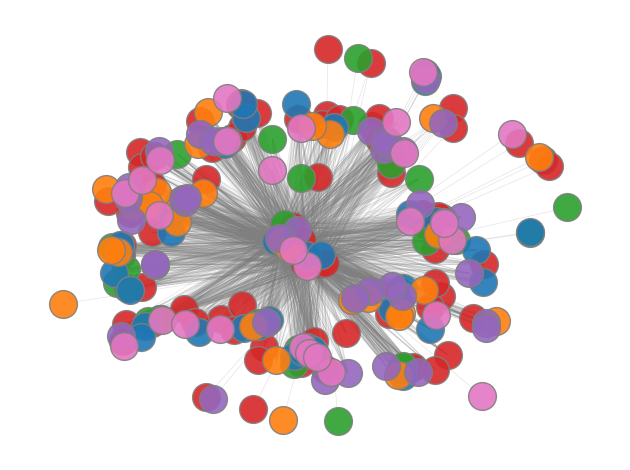

In [10]:
color_map = {'depressive': 'tab:red',
             'anxious': 'tab:green',
             'cyclothymic': 'tab:blue',
             'hyperthymic': 'tab:orange',
             'irritable': 'tab:purple',
             'worrying': 'tab:pink'}

# nodes
pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9}

temperamentos = list(color_map.keys())

for temperamento in temperamentos:
    nodelist = list(filter(lambda node: G.nodes()[node]['temperamento'] == temperamento, list(G.nodes())))
    #print(nodelist)
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=nodelist,
                           node_color=color_map[temperamento],
                           **options)
    

# edges
nx.draw_networkx_edges(G, pos,
                       edgelist=G.edges(),
                       width=0.5,
                       alpha=0.2,
                       edge_color="tab:gray")


plt.tight_layout()
plt.axis("off")
plt.show()

In [11]:
nx.degree_centrality(G)

{'8a': 0.07407407407407408,
 '26c': 0.7613168724279836,
 '26d': 0.7613168724279836,
 '87d': 0.4650205761316873,
 '210a': 0.8024691358024693,
 '210c': 0.8024691358024693,
 '210d': 0.8024691358024693,
 '210h': 0.8024691358024693,
 '210i': 0.8024691358024693,
 '210w': 0.8024691358024693,
 '1002a': 0.8148148148148149,
 '1002c': 0.8148148148148149,
 '1002d': 0.8148148148148149,
 '1002h': 0.8148148148148149,
 '1002i': 0.8148148148148149,
 '1002w': 0.8148148148148149,
 '1014d': 0.8024691358024693,
 '1027d': 1.0,
 '1030d': 0.8189300411522634,
 '8d': 0.07407407407407408,
 '10a': 0.07407407407407408,
 '10c': 0.07407407407407408,
 '10d': 0.07407407407407408,
 '10h': 0.07407407407407408,
 '10i': 0.07407407407407408,
 '10w': 0.07407407407407408,
 '12c': 0.07407407407407408,
 '12d': 0.07407407407407408,
 '12i': 0.07407407407407408,
 '13d': 0.07407407407407408,
 '14c': 0.06995884773662552,
 '14d': 0.06995884773662552,
 '15d': 0.06995884773662552,
 '16d': 0.07407407407407408,
 '17d': 0.074074074074074

In [12]:
communities = {'depressive': [], 'anxious': [], 'cyclothymic': [], 'hyperthymic': [], 'irritable': [], 'worrying': []}

for n, dn in G.nodes(data=True):
    communities[dn['temperamento']].append(n)

communities = list(map(lambda e: set(e), communities.values()))

nx.community.modularity(G, communities)

-0.048611799260500785